In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import geopandas as gpd
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set(style="whitegrid")

In [13]:
df1 = pd.read_csv('df2.csv')
df1.shape

(1686299, 127)

# 12. Supervised Learning Models (Multi Classification)

## 12.1 Sampling of Data

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
df1.columns

Index(['Source', 'Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)',
       'Street', 'State', 'Zipcode', 'Country', 'Timezone',
       ...
       'Wind_Direction_WNW', 'Wind_Direction_WSW', 'Wind_Direction_West',
       'Weather_Condition_Cloudy', 'Weather_Condition_Hail',
       'Weather_Condition_Other', 'Weather_Condition_Rainy',
       'Weather_Condition_Snowy', 'Weather_Condition_Volcanic Ash',
       'Weather_Condition_Windy'],
      dtype='object', length=127)

In [16]:
import pandas as pd
from sklearn.utils import resample

# Assuming df is your DataFrame and 'Severity' is the column
# Split the data by Severity
df_severity_1 = df1[df1['Severity'] == 1]
df_severity_2 = df1[df1['Severity'] == 2]
df_severity_3 = df1[df1['Severity'] == 3]
df_severity_4 = df1[df1['Severity'] == 4]

# Upsample the minority classes
df_severity_1_upsampled = resample(df_severity_1, 
                                   replace=True,     # sample with replacement
                                   n_samples=100000, # to match majority class
                                   random_state=123) # reproducible results

df_severity_4_upsampled = resample(df_severity_4, 
                                   replace=True,     # sample with replacement
                                   n_samples=100000, # to match majority class
                                   random_state=123) # reproducible results

# Downsample the majority classes
df_severity_2_downsampled = resample(df_severity_2, 
                                     replace=False,    # sample without replacement
                                     n_samples=500000, # to match desired quota
                                     random_state=123) # reproducible results

# Combine the resampled classes
balanced_df = pd.concat([df_severity_1_upsampled, df_severity_2_downsampled, 
                         df_severity_3, df_severity_4_upsampled])

# Check the size of the balanced dataframe
print(balanced_df.shape)

(963976, 127)


In [17]:
# Separate the dataset into features and target variable
X = balanced_df.drop(['Severity', 'elapsed_time', 'Start_Lat', 'Start_Lng'], axis=1)  # Exclude 'Year' from features
y = balanced_df['Severity']

# Split the data by year
X_train = X[df1['Year'] <= 2021]
y_train = y[df1['Year'] <= 2021]
X_test = X[df1['Year'] > 2021]
y_test = y[df1['Year'] > 2021]

In [18]:
X.columns

Index(['Source', 'Distance(mi)', 'Street', 'State', 'Zipcode', 'Country',
       'Timezone', 'Airport_Code', 'Temperature(F)', 'Humidity(%)',
       ...
       'Wind_Direction_WNW', 'Wind_Direction_WSW', 'Wind_Direction_West',
       'Weather_Condition_Cloudy', 'Weather_Condition_Hail',
       'Weather_Condition_Other', 'Weather_Condition_Rainy',
       'Weather_Condition_Snowy', 'Weather_Condition_Volcanic Ash',
       'Weather_Condition_Windy'],
      dtype='object', length=123)

## 12.2 Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
# Define a set of parameters to test
param_grid = {
    'n_estimators': [100],
    'min_samples_split': [2]
}

# Initialize the Grid Search model
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters found: {grid_search.best_params_}")

# Use the best estimator to make predictions
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

Best parameters found: {'min_samples_split': 2, 'n_estimators': 100}


In [30]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Accuracy: 0.70
Confusion Matrix:
[[     0  36178   7515      0]
 [     0 147105   1874      5]
 [     0   1275  10833      2]
 [     0  21198    656     21]]
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     43693
           2       0.71      0.99      0.83    148984
           3       0.52      0.89      0.66     12110
           4       0.75      0.00      0.00     21875

    accuracy                           0.70    226662
   macro avg       0.50      0.47      0.37    226662
weighted avg       0.57      0.70      0.58    226662



In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

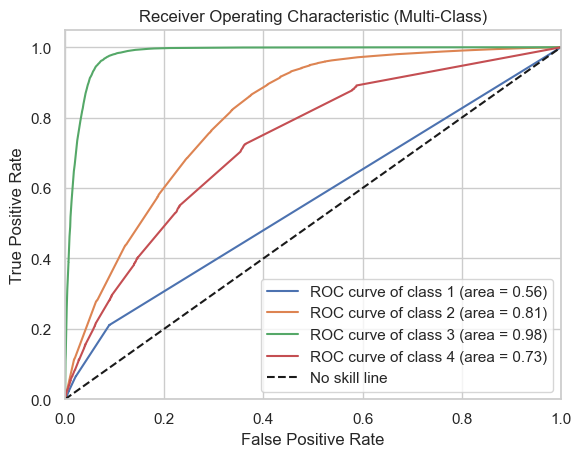

In [32]:
# Binarize the output classes for OvR
y_test_binarized = label_binarize(y_test, classes=[1, 2, 3, 4])
n_classes = y_test_binarized.shape[1]

# Calculate the probabilities for each class
y_prob = grid_search.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i+1} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='No skill line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multi-Class)')
plt.legend(loc="lower right")
plt.show()


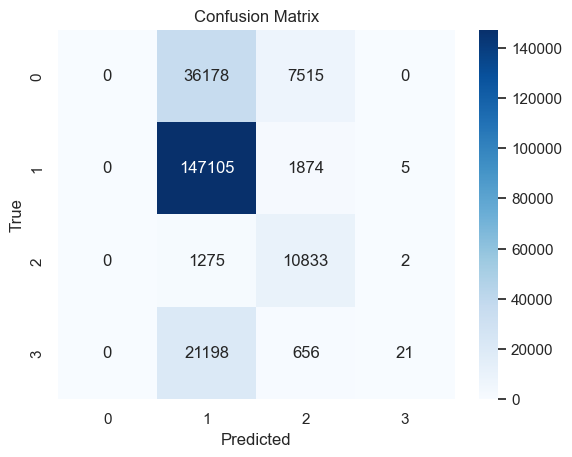

In [33]:
sns.heatmap(confusion_mat, annot=True, fmt='g', cmap='Blues')  # 'fmt' is set to 'g' for generic formatting
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

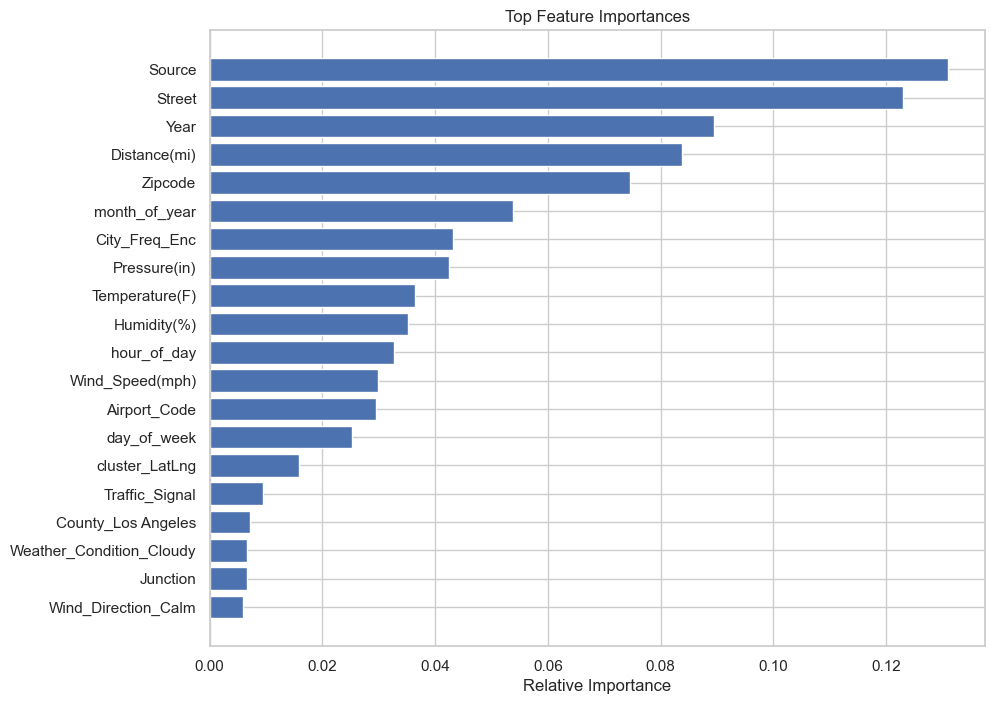

In [34]:
# Get feature importances from the best model
importances = best_rf.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Optionally, select a specific number of top features, for example, top 20
top_n = 20
top_indices = indices[:top_n]

# Visualizing Feature Importances
plt.figure(figsize=(10, 8))
plt.title('Top Feature Importances')
plt.barh(range(len(top_indices)), importances[top_indices], align='center')
plt.yticks(range(len(top_indices)), [X_train.columns[i] for i in top_indices])
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.xlabel('Relative Importance')
plt.show()

## 12.3 XGBoost

In [35]:
import xgboost as xgb

In [36]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjusting the labels to start from 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Convert the datasets to DMatrix data structure
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_adjusted)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_adjusted)

# Set up the parameters for XGBoost
params = {
    'max_depth': 3,  # maximum depth of a tree
    'eta': 0.3,      # learning rate
    'objective': 'multi:softmax',  # multi-class classification using softmax objective
    'num_class': len(set(y_train))  # number of classes
}

# Train the model
num_round = 100  # number of training iterations
bst = xgb.train(params, dtrain, num_round)

In [37]:
# Make predictions
preds = bst.predict(dtest)

# Since we adjusted the labels for training, adjust the predictions back
preds_adjusted = preds + 1

# Calculate accuracy
accuracy = accuracy_score(y_test, preds_adjusted)
print(f"Accuracy: {accuracy}")

# Compute and print the confusion matrix
conf_matrix = confusion_matrix(y_test, preds_adjusted)
print("Confusion Matrix:")
print(conf_matrix)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, preds_adjusted))

Accuracy: 0.6953878462203633
Confusion Matrix:
[[     0  36101   7340    252]
 [     0 147132   1777     75]
 [     0   1753  10231    126]
 [     0  21141    479    255]]
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     43693
           2       0.71      0.99      0.83    148984
           3       0.52      0.84      0.64     12110
           4       0.36      0.01      0.02     21875

    accuracy                           0.70    226662
   macro avg       0.40      0.46      0.37    226662
weighted avg       0.53      0.70      0.58    226662



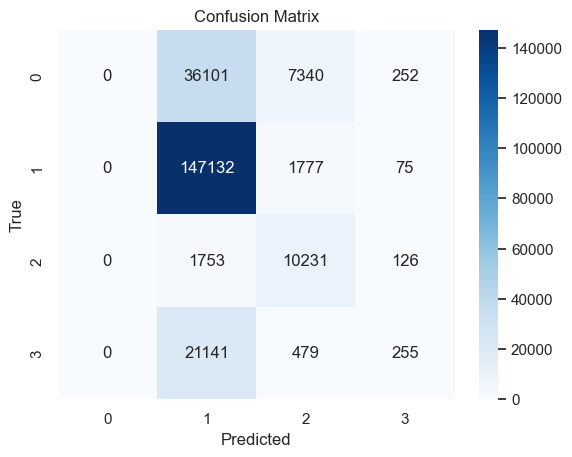

In [38]:
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')  # 'fmt' is set to 'g' for generic formatting
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

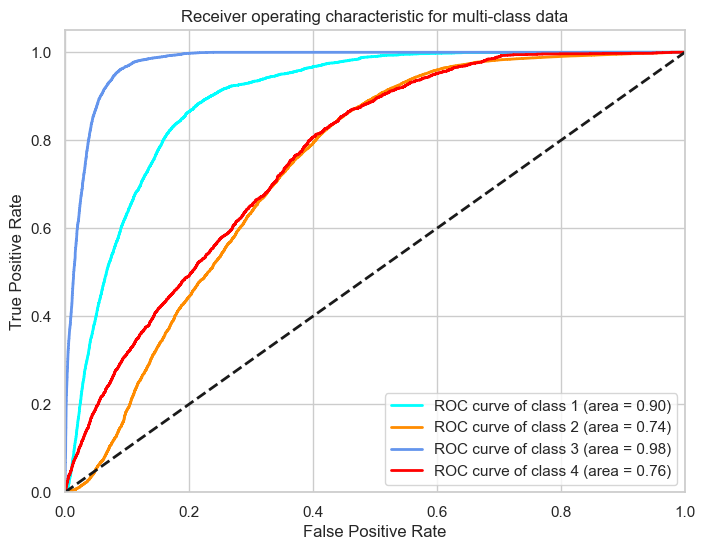

In [39]:
# Modify the params dictionary
params['objective'] = 'multi:softprob'

# Train the model with softprob
bst_prob = xgb.train(params, dtrain, num_round)

# Predict the probabilities for each class
y_test_prob = bst_prob.predict(dtest)

# Binarize the labels for the test set
y_test_binarized = label_binarize(y_test_adjusted, classes=range(len(set(y_train_adjusted))))

# Compute ROC curve and ROC area for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate the ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [40]:
# Get feature importance
importance = bst.get_score(importance_type='weight')
print(importance)


{'f0': 306.0, 'f1': 274.0, 'f2': 347.0, 'f4': 251.0, 'f7': 112.0, 'f8': 34.0, 'f9': 33.0, 'f10': 66.0, 'f12': 41.0, 'f13': 11.0, 'f15': 21.0, 'f17': 19.0, 'f18': 2.0, 'f19': 11.0, 'f21': 16.0, 'f22': 26.0, 'f23': 7.0, 'f24': 34.0, 'f26': 3.0, 'f27': 3.0, 'f28': 8.0, 'f29': 10.0, 'f30': 61.0, 'f31': 102.0, 'f32': 185.0, 'f33': 275.0, 'f34': 138.0, 'f35': 37.0, 'f37': 2.0, 'f38': 6.0, 'f39': 1.0, 'f41': 2.0, 'f43': 5.0, 'f44': 10.0, 'f45': 1.0, 'f46': 3.0, 'f48': 2.0, 'f49': 11.0, 'f50': 9.0, 'f51': 8.0, 'f53': 8.0, 'f54': 2.0, 'f55': 4.0, 'f56': 3.0, 'f57': 2.0, 'f58': 3.0, 'f61': 8.0, 'f62': 10.0, 'f63': 6.0, 'f64': 6.0, 'f65': 6.0, 'f67': 13.0, 'f68': 1.0, 'f69': 3.0, 'f70': 4.0, 'f71': 3.0, 'f72': 15.0, 'f73': 2.0, 'f74': 8.0, 'f75': 4.0, 'f76': 14.0, 'f77': 9.0, 'f78': 7.0, 'f79': 1.0, 'f82': 10.0, 'f83': 18.0, 'f84': 3.0, 'f85': 1.0, 'f88': 11.0, 'f90': 11.0, 'f91': 9.0, 'f92': 2.0, 'f93': 3.0, 'f94': 3.0, 'f96': 1.0, 'f97': 4.0, 'f98': 3.0, 'f99': 1.0, 'f100': 2.0, 'f103': 1.0, 'f

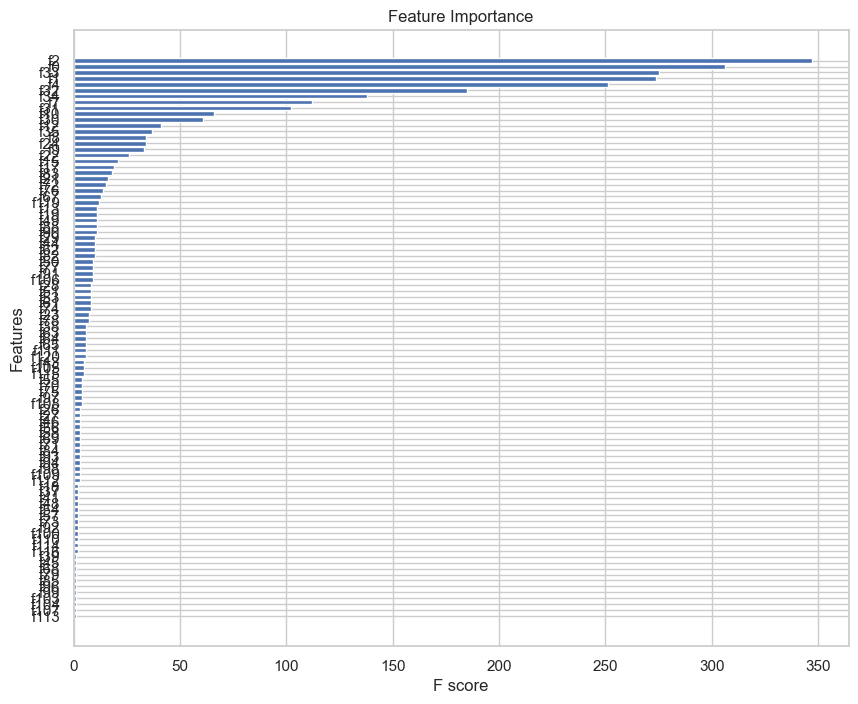

In [41]:
import matplotlib.pyplot as plt

# Sort the feature importance in descending order
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Unzip the feature importance into two lists
features, importance_scores = zip(*sorted_importance)

# Plot the feature importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(features)), importance_scores, align='center')
plt.yticks(range(len(features)), features)
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.xlabel('F score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

## 12.4 Logistic Regression

In [42]:


# You've already standardized your features and adjusted your labels.

# Initialize the logistic regression model
# Note: You may want to adjust the 'max_iter' parameter if the model fails to converge.
logreg = LogisticRegression(max_iter=1000)

# Fit the model on the scaled training data
logreg.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_logreg = logreg.predict(X_test_scaled)
y_pred_proba_logreg = logreg.predict_proba(X_test_scaled)[:, 1]

# Calculate the accuracy of the logistic regression model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {accuracy_logreg:.4f}")

Logistic Regression Accuracy: 0.6542


# 13. Supervised Learning Models (Binary Classification)

## 13.1 Random Forest

In [43]:
# Downsample Severity 2
df_severity_2_downsampled = resample(df1[df1['Severity'] == 2], 
                                     replace=False,    # sample without replacement
                                     n_samples=600000, # number of samples
                                     random_state=123) # for reproducibility

# Take all records of Severity 1
df_severity_1 = df1[df1['Severity'] == 1]

# Take all records of Severity 3 and 4
df_severity_3_4 = df1[df1['Severity'].isin([3, 4])]

# Combine all the datasets
balanced_df2 = pd.concat([df_severity_1, df_severity_2_downsampled, df_severity_3_4])

# Shuffle the combined dataset
balanced_df2 = balanced_df2.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the size of the balanced dataframe
print(balanced_df2.shape)

(886587, 127)


In [44]:
# Separate the dataset into features and target variable
X2 = balanced_df2.drop(['Severity', 'elapsed_time', 'Start_Lat', 'Start_Lng'], axis=1)  # Exclude 'Year' from features
y2 = balanced_df2['Severity']

# Split the data by year
X2_train = X2[balanced_df2['Year'] <= 2021]
y2_train = y2[balanced_df2['Year'] <= 2021]
X2_test = X2[balanced_df2['Year'] > 2021]
y2_test = y2[balanced_df2['Year'] > 2021]

# Assuming y_train and y_test are your original multi-class targets
# You will map 1,2 -> 0 and 3,4 -> 1

y2_train_binary = y2_train.replace({1: 0, 2: 0, 3: 1, 4: 1})
y2_test_binary = y2_test.replace({1: 0, 2: 0, 3: 1, 4: 1})

print(X2_train.shape)
print(X2_test.shape)

(688598, 123)
(197989, 123)


In [45]:
from sklearn.metrics import accuracy_score

# Initialize RandomForestClassifier with oob_score set to True
rf2_classifier = RandomForestClassifier(oob_score=True, random_state=42)

# Fit the model
rf2_classifier.fit(X2_train, y2_train_binary)

# Predict on the training set
y2_train_pred = rf2_classifier.predict(X2_train)
# Predict on the test set
y2_test_pred = rf2_classifier.predict(X2_test)

# Calculate the training and testing accuracy
train_accuracy = accuracy_score(y2_train_binary, y2_train_pred)
test_accuracy = accuracy_score(y2_test_binary, y2_test_pred)

# Calculate training and testing errors
train_error = 1 - train_accuracy
test_error = 1 - test_accuracy

# Get the OOB error
oob_error = 1 - rf2_classifier.oob_score_

# Print the errors
print(f"Training Error: {train_error:.4f}")
print(f"Testing Error: {test_error:.4f}")
print(f"OOB Error: {oob_error:.4f}")

Training Error: 0.0007
Testing Error: 0.0348
OOB Error: 0.0844


In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [47]:
accuracy = accuracy_score(y2_test_binary, y2_test_pred)
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y2_test_binary, y2_test_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y2_test_binary, y2_test_pred)
print("Classification Report:")
print(class_report)

Accuracy: 0.97
Confusion Matrix:
[[180480   2632]
 [  4257  10620]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    183112
           1       0.80      0.71      0.76     14877

    accuracy                           0.97    197989
   macro avg       0.89      0.85      0.87    197989
weighted avg       0.96      0.97      0.96    197989



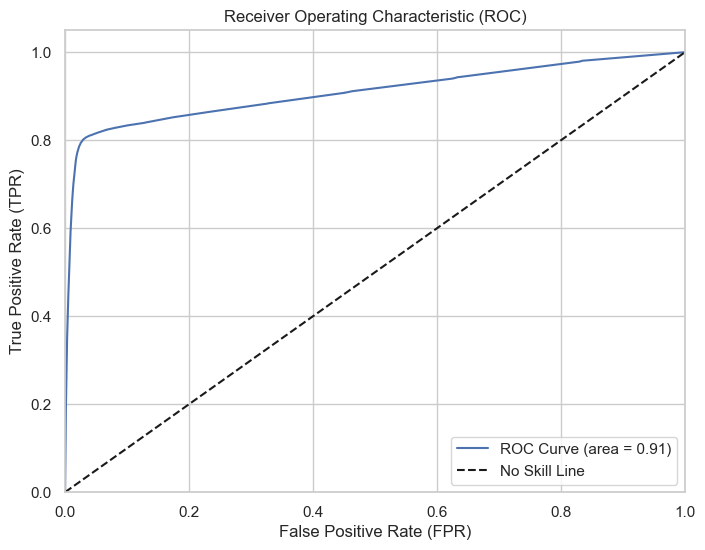

AUC Score: 0.9088


In [48]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for the positive class (class 1)
y2_test_prob = rf2_classifier.predict_proba(X2_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y2_test_binary, y2_test_prob)

# Compute the AUC score
roc_auc = roc_auc_score(y2_test_binary, y2_test_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill Line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print the AUC
print(f"AUC Score: {roc_auc:.4f}")

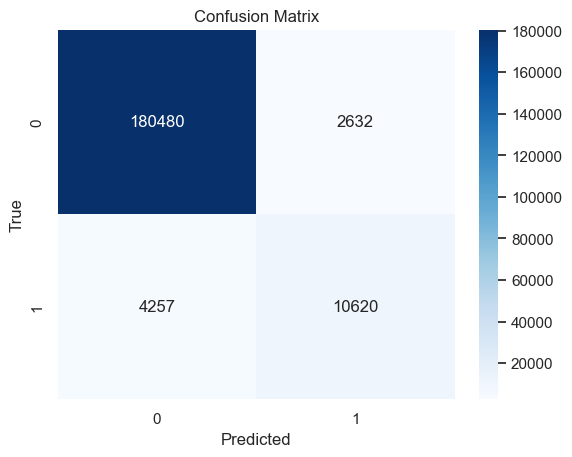

In [49]:
sns.heatmap(confusion_mat, annot=True, fmt='g', cmap='Blues')  # 'fmt' is set to 'g' for generic formatting
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

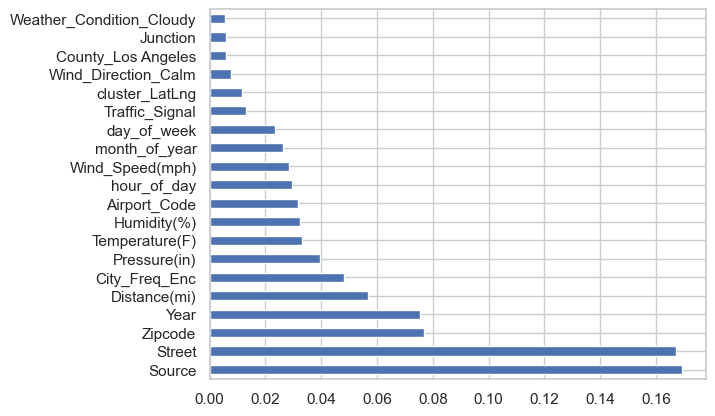

In [50]:
feat_importances = pd.Series(rf2_classifier.feature_importances_, index= X2.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

## 13.2 XGBoost

In [51]:
# Convert the datasets to DMatrix data structure
dtrain2 = xgb.DMatrix(X2_train, label=y2_train_binary)
dtest2 = xgb.DMatrix(X2_test, label=y2_test_binary)

params = {
    'max_depth': 3,  # maximum depth of a tree
    'eta': 0.3,      # learning rate
    'objective': 'binary:logistic',  # binary classification
    'eval_metric': 'logloss'  # evaluation metric
}
num_round = 100  # number of training iterations

bst2 = xgb.train(params, dtrain2, num_round)

Accuracy: 0.9625
Confusion Matrix:
[[180481   2631]
 [  4792  10085]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    183112
           1       0.79      0.68      0.73     14877

    accuracy                           0.96    197989
   macro avg       0.88      0.83      0.86    197989
weighted avg       0.96      0.96      0.96    197989



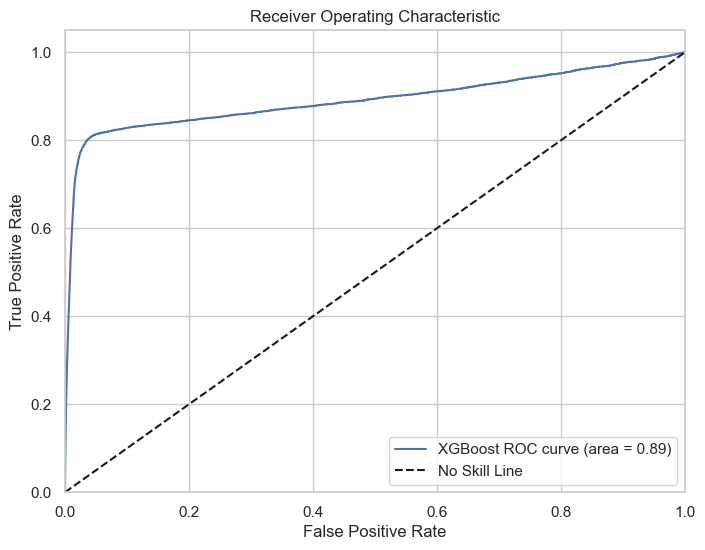

In [52]:
# Make predictions
y2_pred = bst2.predict(dtest2)
y2_pred_binary = (y2_pred > 0.5).astype(int)  # Convert probabilities to binary output

# Calculate accuracy
accuracy = accuracy_score(y2_test_binary, y2_pred_binary)
print(f"Accuracy: {accuracy:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y2_test_binary, y2_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y2_test_binary, y2_pred_binary)
print("Classification Report:")
print(class_report)

# ROC AUC curve
fpr, tpr, _ = roc_curve(y2_test_binary, y2_pred)
roc_auc = roc_auc_score(y2_test_binary, y2_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill Line')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

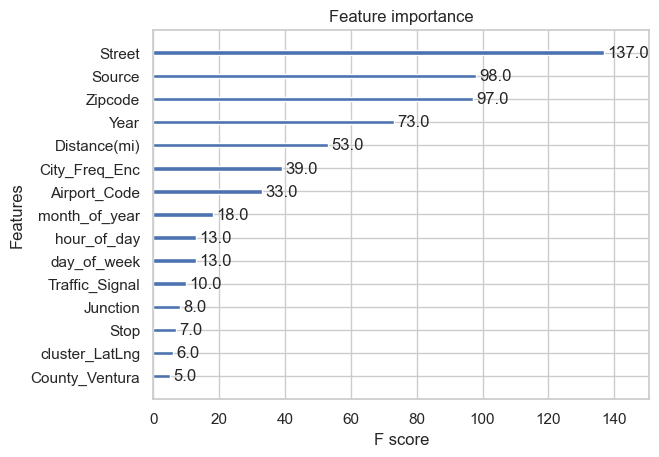

In [53]:
# Plot the feature importance
xgb.plot_importance(bst2, max_num_features=15)  # You can change 'max_num_features' as needed
plt.title('Feature importance')
plt.ylabel('Features')
plt.xlabel('F score')
plt.show()


# 14. Hotspot Calculation

In [54]:
dft = balanced_df2[balanced_df2['Year'] > 2021]
dft.head()

,Source,Severity,Start_Lat,Start_Lng,Distance(mi),Street,State,Zipcode,Country,Timezone,Airport_Code,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,elapsed_time,day_of_week,hour_of_day,month_of_year,Year,City_Freq_Enc,cluster_LatLng,County_Alpine,County_Amador,County_Butte,County_Calaveras,County_Colusa,County_Contra Costa,County_Del Norte,County_El Dorado,County_Fresno,County_Glenn,County_Humboldt,County_Imperial,County_Inyo,County_Kern,County_Kings,County_Lake,County_Lassen,County_Los Angeles,County_Madera,County_Marin,County_Mariposa,County_Mendocino,County_Merced,County_Modoc,County_Mono,County_Monterey,County_Napa,County_Nevada,County_Orange,County_Placer,County_Plumas,County_Riverside,County_Sacramento,County_San Benito,County_San Bernardino,County_San Diego,County_San Francisco,County_San Joaquin,County_San Luis Obispo,County_San Mateo,County_Santa Barbara,County_Santa Clara,County_Santa Cruz,County_Shasta,County_Sierra,County_Siskiyou,County_Solano,County_Sonoma,County_Stanislaus,County_Sutter,County_Tehama,County_Trinity,County_Tulare,County_Tuolumne,County_Ventura,County_Yolo,County_Yuba,Wind_Direction_Calm,Wind_Direction_E,Wind_Direction_ENE,Wind_Direction_ESE,Wind_Direction_East,Wind_Direction_N,Wind_Direction_NE,Wind_Direction_NNE,Wind_Direction_NNW,Wind_Direction_NW,Wind_Direction_North,Wind_Direction_S,Wind_Direction_SE,Wind_Direction_SSE,Wind_Direction_SSW,Wind_Direction_SW,Wind_Direction_South,Wind_Direction_VAR,Wind_Direction_Variable,Wind_Direction_W,Wind_Direction_WNW,Wind_Direction_WSW,Wind_Direction_West,Weather_Condition_Cloudy,Weather_Condition_Hail,Weather_Condition_Other,Weather_Condition_Rainy,Weather_Condition_Snowy,Weather_Condition_Volcanic Ash,Weather_Condition_Windy
0,0,2,36.591,-119.636,0.068,9465,0,65644,0,1,36,92.000,27.000,865.536,2.398,2.303,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.372,3,11,9,2022,0.001,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,3,37.699,-121.930,0.000,49376,0,78249,0,1,55,36.000,89.000,885.658,2.398,0.012,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,1,1,3.409,0,5,1,2022,0.001,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,0,2,32.890,-117.206,0.898,49402,0,35472,0,1,71,73.000,23.000,870.250,2.398,1.946,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.852,3,16,2,2022,0.033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
19,1,2,34.084,-118.298,0.000,37618,0,1309,0,1,23,61.000,44.000,902.402,2.398,0.012,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,3.419,3,9,1,2022,0.092,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29,1,1,37.609,-120.976,0.000,45094,0,95245,0,1,64,79.000,28.000,901.200,2.398,2.565,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3.822,4,13,5,2022,0.005,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 15. Variable Importance for Top three Counties

In [ ]:
counties = ['Los Angeles', 'Santa Clara', 'Orange']
encoded_county_columns = [col for col in balanced_df2.columns if col.startswith('County_') and col.split('_')[1] in counties]
print(encoded_county_columns)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Example for County: Los Angeles
county_a_data = balanced_df2[balanced_df2['County_Los Angeles'] == 1]
X_county_a = county_a_data.drop(['Severity', 'elapsed_time', 'Start_Lat', 'Start_Lng'], axis=1)  # Assuming 'Severity' is your target variable
y_county_a = county_a_data['Severity']

# Split the data by year
X_train_a = X_county_a[county_a_data['Year'] <= 2021]
y_train_a = y_county_a[county_a_data['Year'] <= 2021]
X_test_a = X_county_a[county_a_data['Year'] > 2021]
y_test_a = y_county_a[county_a_data['Year'] > 2021]

# Assuming y_train and y_test are your original multi-class targets
# You will map 1,2 -> 0 and 3,4 -> 1

y_train_binary_a = y_train_a.replace({1: 0, 2: 0, 3: 1, 4: 1})
y_test_binary_a = y_test_a.replace({1: 0, 2: 0, 3: 1, 4: 1})

print(X_train_a.shape)
print(X_test_a.shape)

# Fit a RandomForest model
rf_classifier_a = RandomForestClassifier()
rf_classifier_a.fit(X_train_a, y_train_binary_a)

# Get feature importances
importances = rf_classifier_a.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Select the top 20 features
top_20_indices = indices[:20]

# Visualizing Top 20 Feature Importances
features = X_train_a.columns
plt.figure(figsize=(10, 8))
plt.title('Top 20 Feature Importances in County Los Angeles')
plt.barh(range(20), importances[top_20_indices], align='center')
plt.yticks(range(20), [features[i] for i in top_20_indices])
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.xlabel('Relative Importance')
plt.show()

(27982, 123)
(6704, 123)


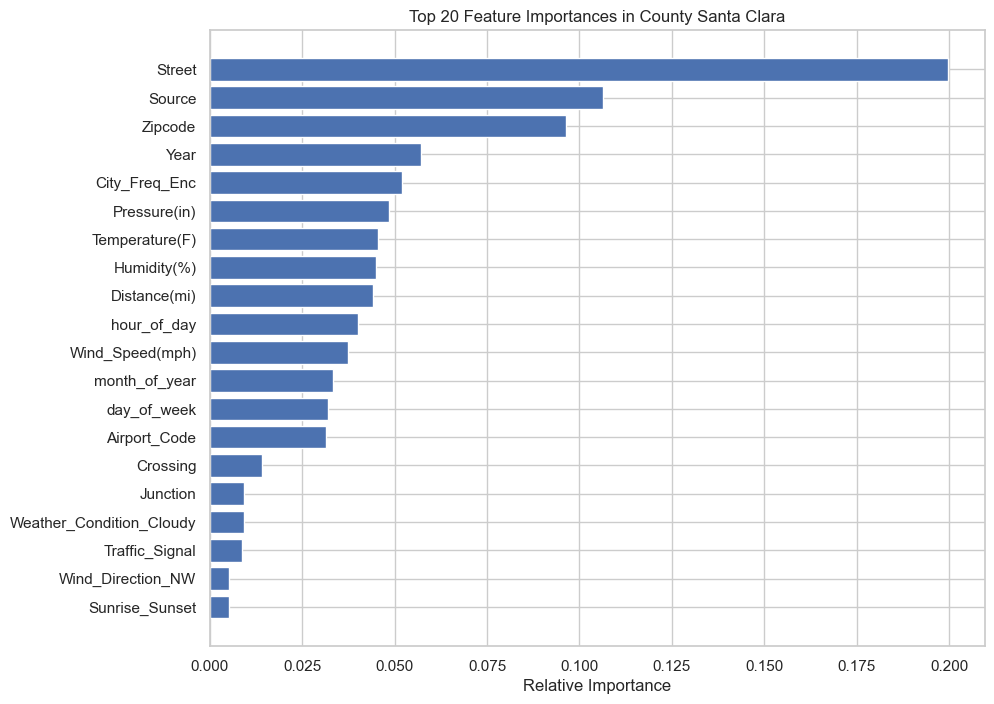

In [56]:
from sklearn.ensemble import RandomForestClassifier

# Example for County: Los Angeles
county_b_data = balanced_df2[balanced_df2['County_Santa Clara'] == 1]
X_county_b = county_b_data.drop(['Severity', 'elapsed_time', 'Start_Lat', 'Start_Lng'], axis=1)  # Assuming 'Severity' is your target variable
y_county_b = county_b_data['Severity']

# Split the data by year
X_train_b = X_county_b[county_b_data['Year'] <= 2021]
y_train_b = y_county_b[county_b_data['Year'] <= 2021]
X_test_b = X_county_b[county_b_data['Year'] > 2021]
y_test_b = y_county_b[county_b_data['Year'] > 2021]

# Assuming y_train and y_test are your original multi-class targets
# You will map 1,2 -> 0 and 3,4 -> 1

y_train_binary_b = y_train_b.replace({1: 0, 2: 0, 3: 1, 4: 1})
y_test_binary_b = y_test_b.replace({1: 0, 2: 0, 3: 1, 4: 1})

print(X_train_b.shape)
print(X_test_b.shape)

# Fit a RandomForest model
rf_classifier_b = RandomForestClassifier()
rf_classifier_b.fit(X_train_b, y_train_binary_b)

# Get feature importances
importances = rf_classifier_b.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Select the top 20 features
top_20_indices = indices[:20]

# Visualizing Top 20 Feature Importances
features = X_train_b.columns
plt.figure(figsize=(10, 8))
plt.title('Top 20 Feature Importances in County Santa Clara')
plt.barh(range(20), importances[top_20_indices], align='center')
plt.yticks(range(20), [features[i] for i in top_20_indices])
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.xlabel('Relative Importance')
plt.show()

(43300, 123)
(12327, 123)


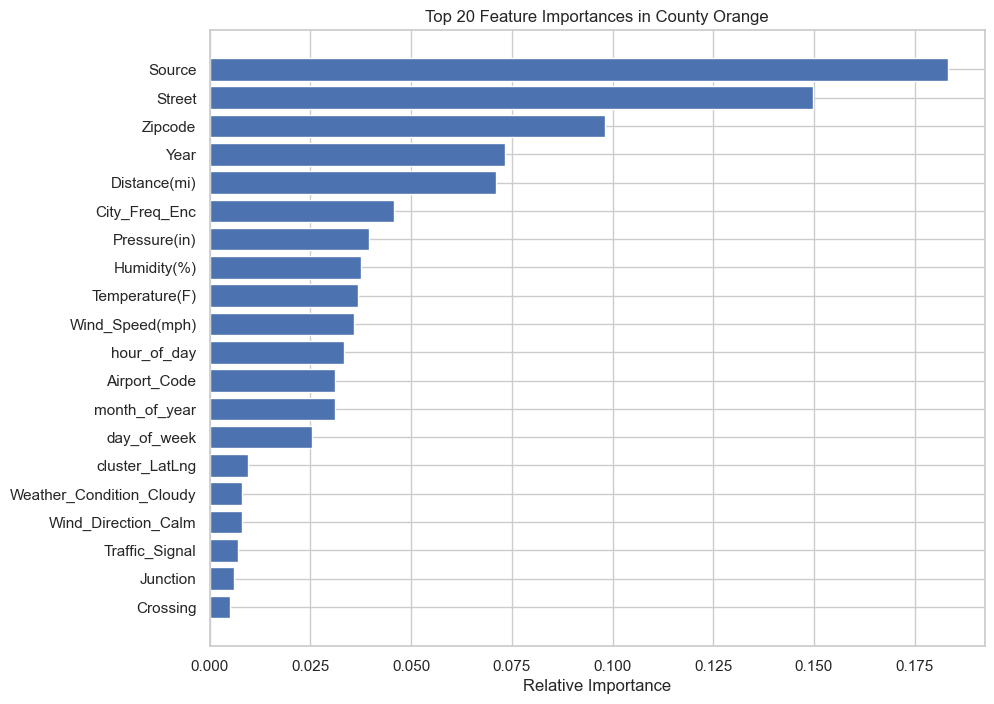

In [60]:
# Example for County: Los Angeles
county_c_data = balanced_df2[balanced_df2['County_Orange'] == 1]
X_county_c = county_c_data.drop(['Severity', 'elapsed_time', 'Start_Lat', 'Start_Lng'], axis=1)  # Assuming 'Severity' is your target variable
y_county_c = county_c_data['Severity']

# Split the data by year
X_train_c = X_county_c[county_c_data['Year'] <= 2021]
y_train_c = y_county_c[county_c_data['Year'] <= 2021]
X_test_c = X_county_c[county_c_data['Year'] > 2021]
y_test_c = y_county_c[county_c_data['Year'] > 2021]

# Assuming y_train and y_test are your original multi-class targets
# You will map 1,2 -> 0 and 3,4 -> 1

y_train_binary_c = y_train_c.replace({1: 0, 2: 0, 3: 1, 4: 1})
y_test_binary_c = y_test_c.replace({1: 0, 2: 0, 3: 1, 4: 1})

print(X_train_c.shape)
print(X_test_c.shape)

# Fit a RandomForest model
rf_classifier_c = RandomForestClassifier()
rf_classifier_c.fit(X_train_c, y_train_binary_c)

# Get feature importances
importances = rf_classifier_c.feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Select the top 20 features
top_20_indices = indices[:20]

# Visualizing Top 20 Feature Importances
features = X_train_c.columns
plt.figure(figsize=(10, 8))
plt.title('Top 20 Feature Importances in County Orange')
plt.barh(range(20), importances[top_20_indices], align='center')
plt.yticks(range(20), [features[i] for i in top_20_indices])
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.xlabel('Relative Importance')
plt.show()

In [61]:
dfs = pd.DataFrame(y2_test_pred, columns=['Severity'])
dfs.head()

,Severity
0,0
1,1
2,0
3,0
4,0


In [62]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load your dataset
# df1 = pd.read_csv('your_dataset.csv')

# Drop rows with missing values in key columns
#dft = dft.dropna(subset=['Start_Lat', 'Start_Lng', 'Severity'])

# Normalize and calculate the product of severity and elapsed time
scaler = MinMaxScaler()
dfs[['Severity']] = scaler.fit_transform(dfs[['Severity']])
dfs['Weight'] = dfs['Severity'] #* dft['elapsed_time']

# Convert your DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(dft, geometry=gpd.points_from_xy(dft['Start_Lng'], dft['Start_Lat']))

# KDE calculation with weights
x = dft['Start_Lng']
y = dft['Start_Lat']
weights = dfs['Weight']
xy = np.vstack([x, y])
kde = gaussian_kde(xy, weights=weights, bw_method='silverman')

# Evaluate KDE on a grid
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
f = np.reshape(kde(positions).T, xx.shape)

# Create the plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Load county shapefile (replace 'path_to_shapefile' with your shapefile's path)
counties = gpd.read_file('CA_Counties_TIGER2016.shp')

# Ensure the CRS of counties matches your map's CRS
counties = counties.to_crs("EPSG:4326")  # EPSG:4326 is the common CRS for WGS84 Lat/Lon

# Overlay the county boundaries
for idx, row in counties.iterrows():
    ax.add_geometries([row['geometry']], crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none')

# Overlay KDE plot
ax.imshow(np.rot90(f), cmap='hot', extent=[xmin, xmax, ymin, ymax], transform=ccrs.PlateCarree(), alpha=0.5)

plt.title('Accident Hotspots Based on Severity and Duration For Predicted Data')
plt.show()

ModuleNotFoundError: No module named 'cartopy'